In [125]:
import os
import pickle
import random
import string

import gensim.downloader as api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from nltk.corpus import stopwords

In [138]:
# Parameters
CONTRIBUTOR: str = "Health Promotion Board"
CATEGORY: str = "live-healthy"
MODEL_NAME: str = "glove-wiki-gigaword-300"
MODEL_DIM: int = MODEL_NAME.split("-")[-1]
POOLING_STRATEGY: str = "mean"
SIMILARITY_METRIC: str = "cos"

In [127]:
CLEAN_DATA_PATH = os.path.join("..", "data", "healthhub_small_clean")

CLEANED_CHUNK_ID_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_chunk_id_list_small_clean.pkl"
)
CLEANED_SOURCE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_source_list_small_clean.pkl"
)
CLEANED_DOMAIN_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_domain_list_small_clean.pkl"
)
CLEANED_TITLE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_title_list_small_clean.pkl"
)
CLEANED_CONTRIBUTOR_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_contributor_list_small_clean.pkl"
)
CLEANED_CONTENT_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_content_list_small_clean.pkl"
)
CLEANED_CATEGORY_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_category_list_small_clean.pkl"
)
CLEANED_EMBEDDING_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH,
    f"healthhub_{MODEL_NAME}_embeddings_small_clean.parquet",
)

In [128]:
nltk.download("stopwords")


def preprocess_text(text):
    # Remove punctuation from the text
    punctuations = set("’" + "—" + string.punctuation)
    no_punct_text = "".join([char for char in text if char not in punctuations])

    # Tokenise text and remove stopwords
    tokens = nltk.word_tokenize(no_punct_text)
    tokens = [w for w in tokens if w.lower() not in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joycelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Metadata

In [129]:
with open(CLEANED_CHUNK_ID_LIST_PATH, "rb") as file:
    loaded_chunk_id = pickle.load(file)  # list of chunk ids

with open(CLEANED_SOURCE_LIST_PATH, "rb") as file:
    loaded_source = pickle.load(file)  # list of hyperlinks

with open(CLEANED_DOMAIN_LIST_PATH, "rb") as file:
    loaded_domain = pickle.load(file)  # website domain

with open(CLEANED_TITLE_LIST_PATH, "rb") as file:
    loaded_title = pickle.load(file)  # list of titles each chunk belongs to

with open(CLEANED_CONTRIBUTOR_LIST_PATH, "rb") as file:
    loaded_contributor = pickle.load(file)  # list of contributors

with open(CLEANED_CONTENT_LIST_PATH, "rb") as file:
    loaded_content = pickle.load(file)  # list of chunks of contents

with open(CLEANED_CATEGORY_LIST_PATH, "rb") as file:
    loaded_category = pickle.load(file)  # list of categories

## Data Preprocessing

In [130]:
df = pd.DataFrame(
    {
        "chunk_id": loaded_chunk_id,
        "doc_source": loaded_source,
        "doc_domain": loaded_domain,
        "doc_title": loaded_title,
        "contributor": loaded_contributor,
        "text": loaded_content,
        "category": loaded_category,
    }
)

df = df[df["contributor"] == CONTRIBUTOR].reset_index(drop=True)
df = df[df["doc_source"].apply(lambda x: x.split("/")[3] == CATEGORY)].reset_index(
    drop=True
)

print(df.shape)

(2008, 7)


In [131]:
df["combined_text"] = None

for source in df["doc_source"].unique():
    combined_text = " ".join(df.query("doc_source == @source")["text"].values)
    indices = df.query("doc_source == @source").index.values
    df.loc[indices, "combined_text"] = combined_text

In [132]:
# unique articles
doc_source_list = []
combined_text_list = []
doc_title_list = []

for source in df["doc_source"].unique():
    combined_text = df[df["doc_source"] == source]["combined_text"].iloc[0]
    doc_title = df[df["doc_source"] == source]["doc_title"].iloc[0]
    doc_source_list.append(source)
    combined_text_list.append(combined_text)
    doc_title_list.append(doc_title)

df_articles = pd.DataFrame(
    {
        "doc_source": doc_source_list,
        "doc_title": doc_title_list,
        "article_text": combined_text_list,
    }
)
df_articles["article_text_clean"] = df_articles["article_text"].apply(preprocess_text)

df_articles.tail()

,doc_source,doc_title,article_text,article_text_clean
583,https://www.healthhub.sg/live-healthy/slip-ups...,slip-ups-dos-and-donts,Slip-Ups : Dos Dont 's Slipped picked cigarett...,slipups dos dont slipped picked cigarette pani...
584,https://www.healthhub.sg/live-healthy/is-my-ba...,is-my-baby%27s-spit-up-normal,Q & : Baby 's Spit-Up Normal ? Find baby spits...,q baby spitup normal find baby spits little ca...
585,https://www.healthhub.sg/live-healthy/awkward_...,awkward_turtle,Make Friends Better Mental Well-being Overcome...,make friends better mental wellbeing overcome ...
586,https://www.healthhub.sg/live-healthy/what-a-w...,what-a-weaning-baby-needs-for-strong-immunity,Weaning Baby Needs Strong Immunity baby reache...,weaning baby needs strong immunity baby reache...
587,https://www.healthhub.sg/live-healthy/warnings...,warningsignsof_dementia,Warning Signs Dementia Dementia normal part ag...,warning signs dementia dementia normal part ag...


In [133]:
df_articles.shape

(588, 4)

## Embeddings

In [134]:
# Load Pretrained Glove Embedding
glove_wiki = api.load(MODEL_NAME)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [135]:
def get_GloVe(text, size, vectors):
    vec = np.zeros(size).reshape(
        (1, size)
    )  # create for size of glove embedding and assign all values 0
    count = 0
    for word in text.split():
        # print('\n word:   ', word)
        try:
            # print('glove vect',vectors[word])
            vec += vectors[word].reshape((1, size))  # update vector with new word
            count += 1  # counts every word in sentence
        except KeyError:
            continue
    if POOLING_STRATEGY == "mean":
        if count != 0:
            vec /= count  # get average of vector to create embedding for sentence
        return vec
    elif POOLING_STRATEGY == "sum":
        return vec

### Test on 1 doc

In [136]:
text = df_articles["article_text_clean"].iloc[0]
text

'building supportive network family friends human beings thrive alone need family friends pillars support especially difficult times strong network supportive family friends helps enhance mental wellbeing learn importance supportive network maintain build one \u200bas saying goes man island everyone needs companionship shoulder lean important surround family friends support comfort times joy distress studies shown supportive relationships strong protective factor mental illnesses helps increase mental wellbeing mean supportive network family friends supportive network family friends mean one seek make many friends possible sake instead one strive focus several important relationships handful people social circle strengthen relationships building maintaining network people trust fall back times difficulty important supportive network family friends basic physiological air water etc safety needs safe neighbourhood job security etc met next stage fulfil social needs need feel sense belong

In [142]:
emb = get_GloVe(text, int(MODEL_DIM), glove_wiki)

In [143]:
emb

array([[-2.02272982e-01,  7.79911399e-02, -3.82910655e-02,
        -1.54227917e-01,  4.82104221e-02,  9.73667992e-03,
        -2.61953843e-02,  7.53203853e-02,  3.87813442e-02,
        -1.40458029e+00,  9.77040258e-02, -6.95622609e-02,
        -3.87407210e-02,  6.17387197e-02, -1.99627199e-02,
        -6.32356281e-02, -7.55174177e-02, -7.43577147e-02,
        -3.72719025e-02, -4.40918225e-02,  2.52666277e-02,
         1.71655502e-01,  1.71108682e-01,  8.66952629e-02,
        -1.42192804e-01,  1.38386585e-02,  1.36697970e-03,
         6.53607831e-02, -3.06309429e-02,  3.72209690e-02,
         2.75208686e-03,  2.11468813e-01, -1.94793417e-01,
        -2.47059955e-02, -6.77062428e-01,  1.52150033e-01,
         8.47471936e-02,  4.66217109e-02, -2.59128763e-02,
        -1.42280002e-01,  2.76126601e-02, -1.28349009e-01,
        -2.84371160e-02, -1.29538613e-01,  2.54122677e-02,
         8.56655600e-02,  1.44746956e-01,  1.18840096e-01,
        -2.76592223e-03,  4.21685958e-02,  9.89517183e-0

In [144]:
emb.shape

(1, 300)

In [145]:
emb[0].shape

(300,)

### loop df

In [147]:
embedding_col = f"{MODEL_NAME}_embeddings"

df_articles[embedding_col] = df_articles["article_text_clean"].apply(
    lambda x: get_GloVe(x, int(MODEL_DIM), glove_wiki)
)

In [148]:
df_articles[embedding_col] = df_articles[embedding_col].apply(lambda x: x[0])

In [149]:
df_articles.tail(2)

,doc_source,doc_title,article_text,article_text_clean,glove-wiki-gigaword-300_embeddings
586,https://www.healthhub.sg/live-healthy/what-a-w...,what-a-weaning-baby-needs-for-strong-immunity,Weaning Baby Needs Strong Immunity baby reache...,weaning baby needs strong immunity baby reache...,"[-0.14036304150957332, 0.1089578872434783, -0...."
587,https://www.healthhub.sg/live-healthy/warnings...,warningsignsof_dementia,Warning Signs Dementia Dementia normal part ag...,warning signs dementia dementia normal part ag...,"[-0.16303171592731427, 0.10033301363483793, 0...."


In [150]:
table = pa.Table.from_pandas(df_articles)
pq.write_table(table, CLEANED_EMBEDDING_LIST_PATH)

In [151]:
embeddings_table = pq.read_table(CLEANED_EMBEDDING_LIST_PATH)
embeddings_df = embeddings_table.to_pandas()
embeddings_df.head()

,doc_source,doc_title,article_text,article_text_clean,glove-wiki-gigaword-300_embeddings
0,https://www.healthhub.sg/live-healthy/building...,buildingasupportivenetwork,Building Supportive Network Family Friends Hum...,building supportive network family friends hum...,"[-0.20227298193468465, 0.07799113993696756, -0..."
1,https://www.healthhub.sg/live-healthy/mental_h...,mental_health_emotional_intelligence_pdf,Develop Emotional Intelligence Give Mental Wel...,develop emotional intelligence give mental wel...,"[-0.1385795055885092, 0.05555257015484607, -0...."
2,https://www.healthhub.sg/live-healthy/meal-ide...,meal-ideas-month-9,Meal Ideas : Month 9 Meal ideas 9-month-old ba...,meal ideas month 9 meal ideas 9monthold baby m...,"[-0.07579600396775482, 0.10606978010023814, 0...."
3,https://www.healthhub.sg/live-healthy/soya_uni...,soya_unique_plant_protein,Soya Bean — Unique Plant Protein Soya bean pro...,soya bean unique plant protein soya bean produ...,"[-0.1003982975137108, 0.22114646304036625, 0.0..."
4,https://www.healthhub.sg/live-healthy/nutritio...,nutrition-for-preschoolers-61-72-months,Nutrition Pre-Schoolers ( Months 61-72 ) guide...,nutrition preschoolers months 6172 guide eatin...,"[-0.09614890510287216, 0.14872577408826582, 0...."


## Similarity Score

In [152]:
ground_df = pd.read_excel(
    os.path.join(
        "..", "data", "Synapxe Content Prioritisation - Live Healthy_020724.xlsx"
    ),
    sheet_name="All Live Healthy",
    index_col=False,
)

In [153]:
merge_df = pd.merge(
    embeddings_df, ground_df, how="left", left_on="doc_source", right_on="URL"
)
merge_df = merge_df[[*embeddings_df.columns, "Combine Group ID", "Page Title"]]
merge_df = merge_df[merge_df["Combine Group ID"].notna()]
merge_df = merge_df.sort_values(by="Combine Group ID").reset_index(drop=True)
merge_df["Combine Group ID"] = merge_df["Combine Group ID"].astype(int)

In [154]:
print(merge_df.shape)
merge_df.sample(2)

(187, 7)


,doc_source,doc_title,article_text,article_text_clean,glove-wiki-gigaword-300_embeddings,Combine Group ID,Page Title
62,https://www.healthhub.sg/live-healthy/build_he...,build_healthy_food_foundation,Build Healthy Diet Meal Plan Eating healthy di...,build healthy diet meal plan eating healthy di...,"[-0.10493682211403266, 0.21074671269715986, 0....",19,Build a Healthy Diet Meal Plan
20,https://www.healthhub.sg/live-healthy/child-si...,child-sixth-year-healthy-screen-habits,Child ’ Sixth Year : Healthy Screen Time Habit...,child sixth year healthy screen time habits ti...,"[-0.15360225103194675, 0.0804545440778677, -0....",9,Child’s Sixth Year: Healthy Screen Time Habits


In [155]:
def pairwise_similarity(matrix_of_vectors):
    """
    Computes cosine similarities for between all vectors, extremely useful for comparing
    similarities between embeddings when doing deep embedding learning.

    input:
        matrix_of_vectors: tensor with shape (n_vectors, vector_size)

    output:
        similarities : tensor with shape (n_vector, n_vectors)
    Each row[i, j] is the similarity of the ith element against the jth vector, eg,
    row[0,0] is 1 and row[0,42] is the similarity between the first
    element in the input and the 43th element in the input.
    """

    dot_product = np.dot(matrix_of_vectors, matrix_of_vectors.T)
    norms = np.linalg.norm(matrix_of_vectors, axis=1)
    similarities = dot_product / np.outer(norms, norms)

    return similarities


# Function to darken a hex color
def darken_hex_color(hex_color, factor=0.7):
    # Ensure factor is between 0 and 1
    factor = max(0, min(1, factor))

    # Convert hex color to RGB
    r = int(hex_color[1:3], 16)
    g = int(hex_color[3:5], 16)
    b = int(hex_color[5:7], 16)

    # Darken the color
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)

    # Convert RGB back to hex
    darkened_color = f"#{r:02x}{g:02x}{b:02x}".upper()

    return darkened_color

### First 20 docs

In [156]:
start = 0
end = 20

article_titles = merge_df.loc[:, "doc_title"].tolist()
cutoff_article_titles = article_titles[start:end]
# filter on articles in list
df_articles_filtered = df_articles[df_articles["doc_title"].isin(cutoff_article_titles)]
# reorder rows according to list
df_articles_filtered["doc_title"] = pd.Categorical(
    df_articles_filtered["doc_title"], categories=cutoff_article_titles, ordered=True
)
df_articles_filtered = df_articles_filtered.sort_values(by="doc_title").reset_index(
    drop=True
)

# Get the embeddings to compute the similarities
embeddings_series = df_articles_filtered[embedding_col]
embeddings = np.vstack(embeddings_series)
print(embeddings.shape)  # (num_documents, embedding_dim)

# Calculate the embedding similarities
similarities = pairwise_similarity(embeddings)

print(similarities.shape)

(20, 300)
(20, 20)


C:\Users\Joycelyn\AppData\Local\Temp\ipykernel_2636\2257592904.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_articles_filtered["doc_title"] = pd.Categorical(


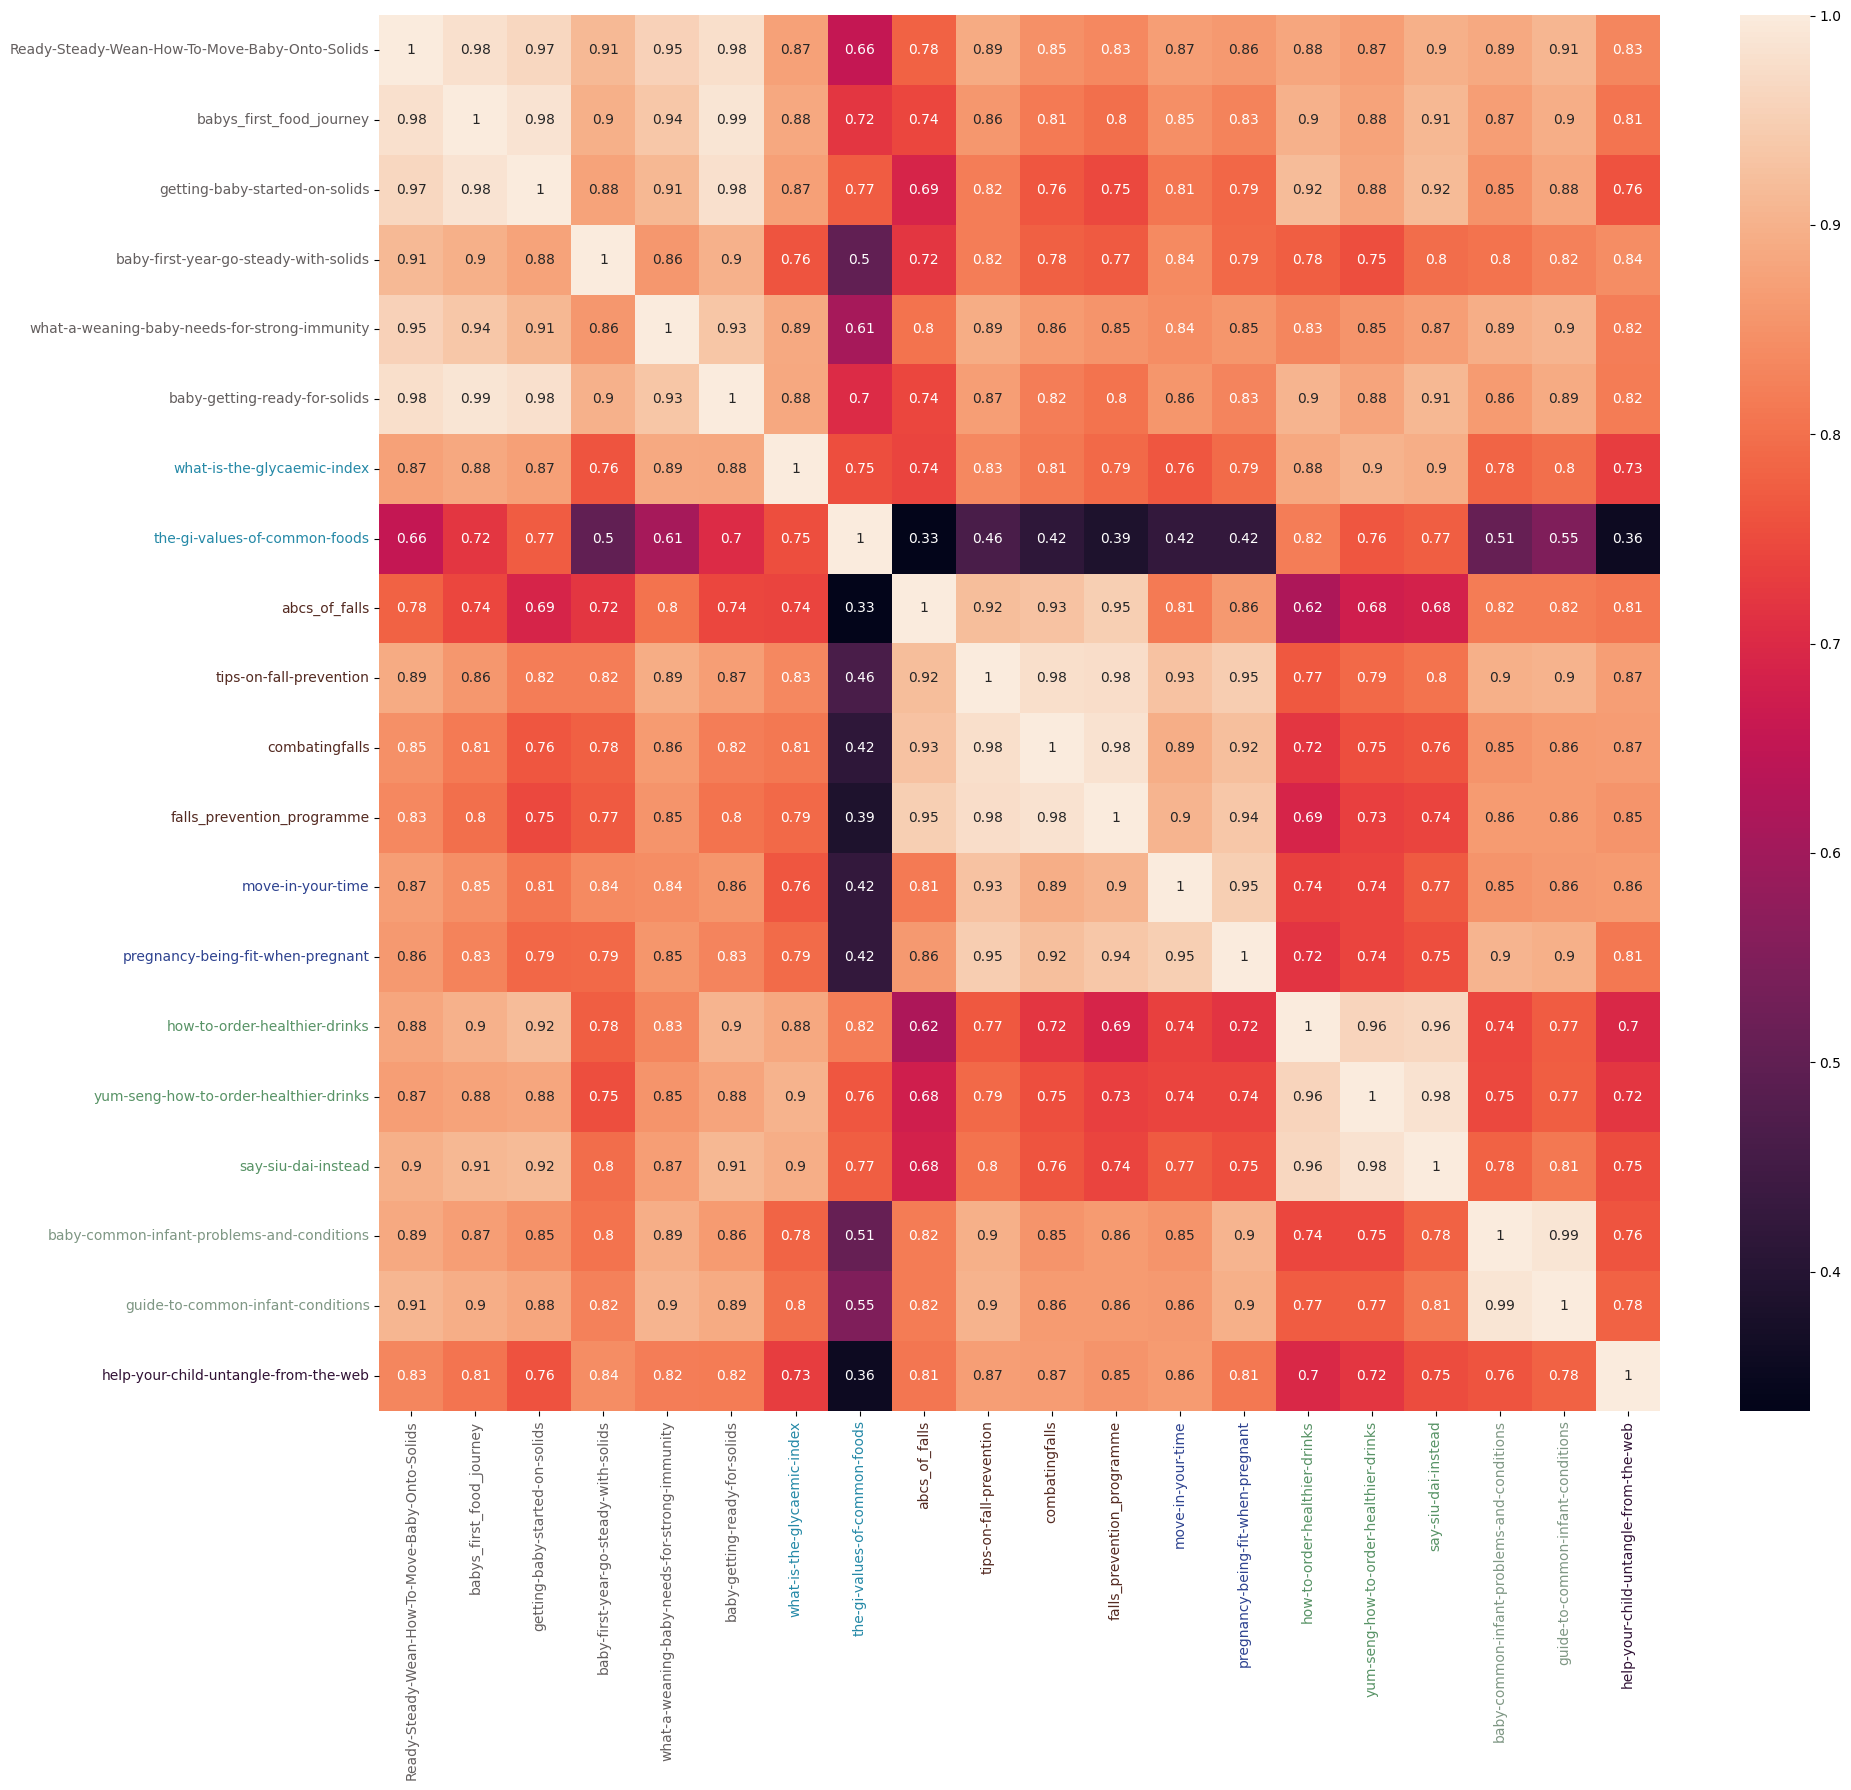

In [157]:
hexadecimal_alphabets = "0123456789ABCDEF"
ground_truth_cluster_ids = merge_df.iloc[start:end]["Combine Group ID"].unique()

colours = {
    id: darken_hex_color(
        "#" + "".join([random.choice(hexadecimal_alphabets) for _ in range(6)])
    )
    for id in ground_truth_cluster_ids
}

plt.figure(figsize=(20, 18))  # Adjust figure size as desired
ax = sns.heatmap(
    similarities,
    xticklabels=cutoff_article_titles,
    yticklabels=cutoff_article_titles,
    annot=True,
    fmt=".2g",
)  # Customize colormap if needed

for x_tick_label, y_tick_label in zip(
    ax.axes.get_xticklabels(), ax.axes.get_yticklabels()
):
    ground_truth_cluster_id = (
        merge_df[merge_df["doc_title"] == y_tick_label.get_text()]["Combine Group ID"]
        .values[0]
        .astype(int)
    )
    colour = colours[ground_truth_cluster_id]
    y_tick_label.set_color(colour)
    x_tick_label.set_color(colour)

plt.tight_layout()
plt.show()

### Matrix (187 docs)

In [158]:
# filter on articles in list
article_titles = merge_df.loc[:, "doc_title"].tolist()
df_articles_filtered = df_articles[df_articles["doc_title"].isin(article_titles)]
df_articles_filtered.shape

# reorder rows according to list
df_articles_filtered["doc_title"] = pd.Categorical(
    df_articles_filtered["doc_title"], categories=article_titles, ordered=True
)
df_articles_filtered = df_articles_filtered.sort_values(by="doc_title").reset_index(
    drop=True
)

# Get the embeddings to compute the similarities
embeddings_series = df_articles_filtered[embedding_col]
embeddings = np.vstack(embeddings_series)
print(embeddings.shape)  # (num_documents, embedding_dim)

# Calculate the embedding similarities
similarities = pairwise_similarity(embeddings)
print(similarities.shape)

similarities_df = pd.DataFrame(similarities)
similarities_df.columns = merge_df["Page Title"]
similarities_df.index = merge_df["Page Title"]
similarities_df

similarities_df.to_csv(
    rf"..\artifacts\outputs\{MODEL_NAME}_{POOLING_STRATEGY}_{SIMILARITY_METRIC}_similarity_score.csv"
)

(187, 300)
(187, 187)


C:\Users\Joycelyn\AppData\Local\Temp\ipykernel_2636\3790568168.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_articles_filtered["doc_title"] = pd.Categorical(
